In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from copy import deepcopy

In [2]:
st = pd.HDFStore(os.path.expanduser("/Users/nipunbatra/wiki-all.h5"))

In [3]:
metadata_df = pd.read_csv("/Users/nipunbatra/w/dataport-metadata.csv",index_col=0)

In [5]:
months=3
start='7-1-2014'
start_month=7
end = '9-30-2014'
end_month=10

In [6]:
sd_df = pd.read_csv("../data/input/san_diego_df.csv", index_col=0)
au_df = pd.read_csv("../data/input/austin_df.csv", index_col=0)

In [7]:
import json
sd_homes = json.load(open("../data/input/san_diego_homes.json",'r'))
au_homes = json.load(open("../data/input/austin_homes.json",'r'))

In [8]:
K_min, K_max = 1,6
F_min, F_max=1,8

#from all_functions import *
#from features import *

import sys

from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import LeaveOneOut

NUM_NEIGHBOUR_MAX = 6
F_MAX = 4

import json

feature_map = {'Monthly':['aggregate_%d' %month for month in range(start_month, end_month)],
              'Static':['area'],
              'Monthly+Static':np.hstack([['aggregate_%d' %month for month in range(start_month, end_month)],
                                        'area']).flatten().tolist()}



from sklearn.cross_validation import LeaveOneOut
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from collections import OrderedDict

In [9]:
train_dataset_df = au_df
test_dataset_df = sd_df
train_all_homes = au_homes
test_all_homes = sd_homes

In [10]:
def _find_accuracy(home, appliance, feature="Monthly"):
    if appliance =="hvac":
        start, stop=7,10
    else:
        start, stop=7, 10

    np.random.seed(42)
    appliance_df = train_dataset_df.ix[train_all_homes[appliance]]
    appliance_df_test = test_dataset_df.ix[test_all_homes[appliance]]
    
    #ADDING NEW
    appliance_df = appliance_df.ix[appliance_df[feature_map[feature]].dropna().index]
    
    
    test_homes = [home]
    train_homes = appliance_df[~appliance_df.index.isin([home])].index
    all_home_appliance = deepcopy(train_all_homes)
    all_home_appliance[appliance] = train_homes

    # Cross validation on inner loop to find best feature, K
    train_size = len(train_homes)
    l = LeaveOneOut(train_size)
    out = OrderedDict()
    for cv_train, cv_test in l:

        cv_train_home=appliance_df.ix[train_homes[cv_train]]
        cv_test_home = appliance_df.ix[train_homes[cv_test]]
        test_home_name = cv_test_home.index.values[0]
        #print cv_test_home
        out[test_home_name]={}


        # Summing up energy across start to stop to get Y to learn optimum feature on
        Y = cv_train_home[['%s_%d' %(appliance, i) for i in range(start, stop)]].sum(axis=1).values
        forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)
        forest.fit(cv_train_home[feature_map[feature]], Y)
        importances = forest.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Now varying K and top-N features

        for K in range(K_min, K_max):
            out[test_home_name][K]={}
            for top_n in range(F_min,F_max):
                out[test_home_name][K][top_n]=[]
                top_n_features = cv_train_home[feature_map[feature]].columns[indices][:top_n]

                # Now fitting KNN on this
                for month in range(start, stop):
                    clf = KNeighborsRegressor(n_neighbors=K)
                    clf.fit(cv_train_home[top_n_features], cv_train_home['%s_%d' %(appliance, month)])
                    out[test_home_name][K][top_n].append(clf.predict(cv_test_home[top_n_features]))

        # Now, finding the (K, top_n) combination that gave us best accuracy on CV test homes
    accur = {}

    for K in range(K_min, K_max):
        accur[K] = {}
        for top_n in range(F_min, F_max):
            temp = {}
            for h in out.iterkeys():
                pred = pd.DataFrame(out[h][K][top_n]).T
                #all_but_h = [x for x in out.keys() if x!=h]
                pred.index = [h]
                pred.columns = [['%s_%d' %(appliance, i) for i in range(start, stop)]]
                gt = appliance_df.ix[h][['%s_%d' %(appliance, i) for i in range(start, stop)]]
                error = (pred-gt).abs().div(gt).mul(100)
                mean_error = error.mean().mean()
                a = 100-mean_error
                if a<0:
                    a=0
                temp[h]=a
            ac = pd.Series(temp).mean()

            accur[K][top_n] = ac

    accur_df = pd.DataFrame(accur)
    accur_max = accur_df.max().max()
    max_ac_df = accur_df[accur_df==accur_max]
    F_best = cv_train_home[feature_map[feature]].columns[indices][:max_ac_df.mean(axis=1).dropna().index.values[0]].tolist()
    K_best = max_ac_df.mean().dropna().index.values[0]

    # Now predicting for test home
    
    train_overall = appliance_df.ix[appliance_df[~appliance_df.index.isin([home])].index]
    test_overall = appliance_df_test[appliance_df_test.index.isin([home])]
    pred_test = {}
    gt_test = {}
    for month in range(start, stop):
        clf = KNeighborsRegressor(n_neighbors=K_best)
        clf.fit(train_overall[F_best], train_overall['%s_%d' %(appliance, month)])
        pred_test[month] = clf.predict(test_overall[F_best])
        gt_test[month] = test_overall['%s_%d' %(appliance, month)]

    #print {'f':F_best, 'k':K_best,'accuracy':accur_max}
    #json.dump({'f':F_best, 'k':K_best,'accuracy':accur_max},open("../main-out-new/%s_%s_%d.json" %(appliance,feature, home),"w") )

    pred_df = pd.DataFrame(pred_test)
    pred_df.index = [home]
    gt_df = pd.DataFrame(gt_test)
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    accuracy_test = 100-error
    accuracy_test[accuracy_test<0]=0

    return pred_df, gt_df, accuracy_test.squeeze()

In [14]:
acc = {}

In [15]:
#for appliance in ["hvac","fridge","dw","mw"]:
for appliance in ["hvac"]:
    if appliance in acc:
        continue
    else:
        print appliance
        acc[appliance] = {}
        feature="Monthly"
        for home in sd_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc[appliance][home]=out_df
                print home, acc[appliance][home].mean(), gt.mean(), pred.mean()
            except Exeption, e:
                print e

hvac
54 0.0 7    149.310196
8    158.417160
9    120.083450
dtype: float64 7    415.808142
8    452.679395
9    269.682587
dtype: float64
203 0.244362926926 7    258.869934
8    232.730652
9    174.584366
dtype: float64 7    571.713031
8    615.523615
9    347.888873
dtype: float64
1450 17.9734446129 7    296.445068
8    454.090759
9    469.634796
dtype: float64 7    783.531573
8    991.938281
9    686.040942
dtype: float64
1731 11.1988428704 7    289.619293
8    305.011932
9    390.342133
dtype: float64 7    881.856812
8    994.595459
9    649.542859
dtype: float64
2354 0.0 7    350.511749
8    297.995850
9    309.096863
dtype: float64 7    881.856812
8    994.595459
9    649.542859
dtype: float64
2606 31.4782878756 7    286.592285
8    325.527496
9    420.435608
dtype: float64 7    649.709906
8    778.754919
9    443.833423
dtype: float64
3687 0.0 7    289.946289
8    325.588562
9    266.525909
dtype: float64 7     883.506531
8    1043.603735
9     673.808862
dtype: float64
3864 23.3

In [16]:
acc_hvac_df = pd.DataFrame(acc['hvac'])
acc_hvac_df.T.mean()

7     3.988696
8     2.391048
9    43.554377
dtype: float64

In [98]:
acc_hvac_df.loc[9, 3938] = np.NaN
acc_hvac_df.loc[8, 5938] = np.NaN
acc_hvac_df.T.mean()

7    44.749309
8    46.812934
9    28.613499
dtype: float64

In [61]:
mean_across_months = {}
for appliance in acc.keys():
    if appliance =="hvac":
        mean_across_months[appliance] = pd.Series(acc[appliance])
    else:
        mean_across_months[appliance] = pd.DataFrame(acc[appliance])
    

mean_across_months['hvac'].ix[5938] = np.NaN
#mean_across_months['hvac'].loc[9, 3938] = np.NaN

for appliance in mean_across_months.keys():
    if appliance!="hvac":
        mean_across_months[appliance] = mean_across_months[appliance].mean()
    

In [100]:
mean_across_months['hvac']

54      81.210960
203     50.737098
1450    54.651910
1731    71.579131
2354    60.952957
2606    78.217286
3687    55.787366
3864    70.797060
3938    33.090385
4083     0.000000
4095    48.854592
4934     0.000000
5938          NaN
6377    34.235960
6429     0.000000
6547     0.000000
7114    43.863030
7409    98.336702
7639    89.800570
8061    99.156778
8342     0.000000
8574    96.513671
8733    61.239382
9213    16.457895
9370    25.195088
9585    75.415623
9612    72.618676
9775    85.978243
dtype: float64

In [103]:
acc_hvac_df.T.mean()

7    44.749309
8    46.812934
9    28.613499
dtype: float64

In [62]:
pd.DataFrame(mean_across_months).mean()

fridge    62.190316
hvac      52.025569
dtype: float64

In [38]:
pd.DataFrame(acc['fridge']).mean().mean()

66.345456743663

In [24]:
c

50.737098481969113

In [93]:
#for appliance in ["hvac","fridge","dw","mw"]:
for appliance in ["fridge"]:
    if appliance in acc:
        continue
    else:
        print appliance
        acc[appliance] = {}
        feature="Monthly"
        for home in all_homes[appliance][:]:
            try:
                pred, gt, out_df = _find_accuracy(home, appliance, feature)
                acc[appliance][home]=out_df
                print home, acc[appliance][home].mean()
            except Exeption, e:
                print e

fridge
54 81.4529503361
203 88.3003759185
1450 70.540513228
1731 31.2878602248
3687 43.5346603354
3864 92.6257022841
3938 87.4032924211
4083 83.8102816617
4095 67.3482630646
4495 88.1725944612
4934 89.1231268574
5938 94.2956159831
6377 95.8902776279
6429 71.5263009356
6547 75.1006989373
7062 78.8630367847
7114 78.7667238394
7409 67.3839950875
7639 85.5327726612
8061 82.1900061377
8342 74.8583235184
8574 87.1108981653
8733 57.4837607388
9213 83.4725887971
9370 73.2653082508
9585 71.8400537363
9612 89.5059672631
9775 88.6611605417


In [94]:
mean_across_months = {}
for appliance in acc.keys():
    mean_across_months[appliance] = pd.DataFrame(acc[appliance])
    

mean_across_months['hvac'].loc[8, 5938] = np.NaN
mean_across_months['hvac'].loc[9, 3938] = np.NaN

for appliance in mean_across_months.keys():
    mean_across_months[appliance] = mean_across_months[appliance].mean()
    

In [95]:
pd.DataFrame(mean_across_months).mean()

fridge    77.833825
hvac      77.289600
dtype: float64

In [92]:
pd.DataFrame(mean_across_months).sem()

hvac    2.863358
dtype: float64

### Now looking into homes with poor accuracy and finding the reasons for the same

#### HVAC

Home 4495

In [31]:
df[['hvac_6', 'hvac_7','hvac_8','hvac_9']]

,hvac_6,hvac_7,hvac_8,hvac_9
54,59.545918,149.310196,158.417160,120.083450
203,117.136047,258.869934,232.730652,174.584366
1450,122.322098,296.445068,454.090759,469.634796
1731,36.700634,289.619293,305.011932,390.342133
2354,57.677986,350.511749,297.995850,309.096863
2606,130.427185,286.592285,325.527496,420.435608
3687,112.662666,289.946289,325.588562,266.525909
3864,0.915483,125.890953,202.170044,321.311798
3938,0.002417,61.706448,68.106033,7.287033
4083,0.071050,66.353279,47.636971,43.062366


In [40]:
home=3938
appliance="hvac"
feature="Monthly"
pred, gt, out_df = _find_accuracy(home, appliance, feature)
out_df

8    45.642912
9     0.000000
Name: 3938, dtype: float64

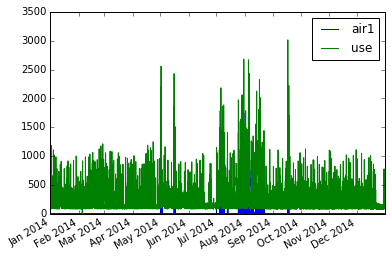

In [36]:
st['/3938'][['air1','use']]['2014'].plot()

3938 was hardly used! 

In [47]:
%matplotlib inline

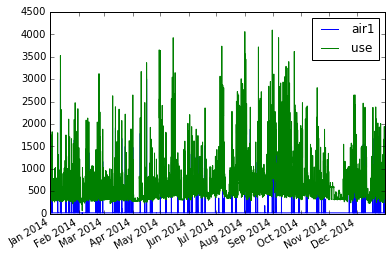

In [49]:
st['/7062'][['air1','use']]['2014'].plot()

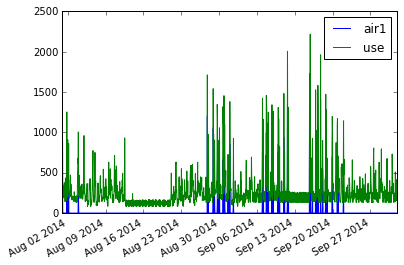

In [52]:
st['/4495'][['air1','use']]['8-1-2014':'10-1-2014'].plot()

7062 has very less usgae and maybe is some data error. Should be removed from analysis!

In [ ]:
5938- Put np.NaN on 8th month
7062-  Exclude from set of homes
3938- Put np.NaN on 9th month
4495- Hardly used. Exclude from set of home


In [96]:
df[['fridge_6', 'fridge_7','fridge_8','fridge_9']]

,fridge_6,fridge_7,fridge_8,fridge_9
54,37.451565,37.834301,38.103199,28.727217
203,48.030052,56.448948,44.765385,39.742134
1450,65.856636,72.587753,54.018948,52.222767
1731,40.344700,44.515667,45.955036,42.599567
2354,NaN,NaN,NaN,NaN
2606,NaN,NaN,NaN,NaN
3687,133.440353,140.171219,138.987930,130.501511
3864,37.346516,42.800053,41.861118,41.774750
3938,36.528286,47.456169,42.763733,41.923233
4083,32.956615,36.872147,39.073502,29.292915


In [65]:
len(sd_homes['fridge'])

28

In [66]:
len(sd_homes['hvac'])

28

In [67]:
len(bo_homes['hvac'])

19

In [68]:
len(bo_homes['fridge'])

29

In [70]:
import matplotlib.pyplot as plt
import sys
sys.path.append("../code/")
from common_functions import tableau20blind, format_axes

In [72]:
%matplotlib inline

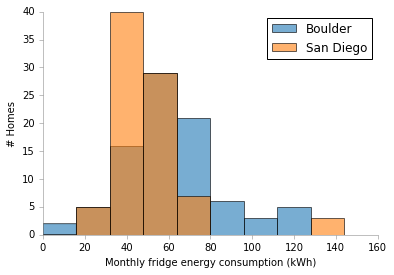

In [86]:
pd.Series(bo_df[['fridge_7','fridge_8','fridge_9']].dropna().values.flatten()).hist(label="Boulder",color=tableau20blind[0],
                                                                                    alpha=0.6, bins=10, range=(0,160))
plt.grid(False)
format_axes(plt.gca())
plt.xlabel("Monthly fridge energy consumption (kWh)")

plt.ylabel("# Homes")
ax = plt.gca()
pd.Series(sd_df[['fridge_7','fridge_8','fridge_9']].dropna().values.flatten()).hist(label="San Diego",color=tableau20blind[2],
                                                                                    ax=ax, alpha=0.6, bins=10, range=(0,160))
plt.grid(False)
format_axes(plt.gca())
plt.xlabel("Monthly fridge energy consumption (kWh)")

plt.ylabel("# Homes")
plt.legend()

plt.savefig("../results/fridge_hist.png")

In [ ]:
pd.Series(bo_df[['hvac_7','hvac_8','hvac_9']].dropna().values.flatten()).hist(label="Boulder",color=tableau20blind[0],
                                                                                    alpha=0.6, bins=10, range=(0,160))
plt.grid(False)
format_axes(plt.gca())
plt.xlabel("Monthly fridge energy consumption (kWh)")

plt.ylabel("# Homes")
ax = plt.gca()
pd.Series(sd_df[['fridge_7','fridge_8','fridge_9']].dropna().values.flatten()).hist(label="San Diego",color=tableau20blind[2],
                                                                                    ax=ax, alpha=0.6, bins=10, range=(0,160))
plt.grid(False)
format_axes(plt.gca())
plt.xlabel("Monthly fridge energy consumption (kWh)")

plt.ylabel("# Homes")
plt.legend()

#plt.savefig("../results/fridge_hist.png")

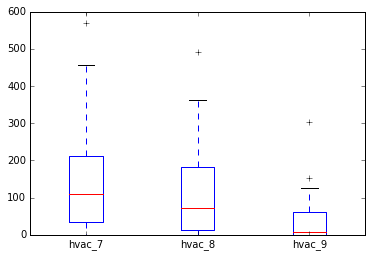

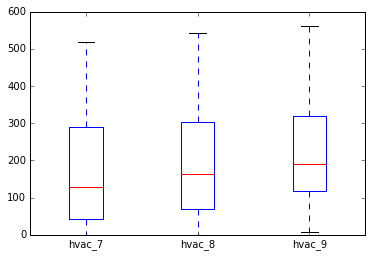

In [110]:
bo_df[['hvac_7','hvac_8','hvac_9']].plot(kind="box")
sd_df[['hvac_7','hvac_8','hvac_9']].plot(kind="box")


In [17]:
sd_df[['hvac_7','hvac_8','hvac_9']].hist(color=tableau20blind[0])
au_df[['hvac_7','hvac_8','hvac_9']].hist(color=tableau20blind[2])

NameError: name 'tableau20blind' is not defined

In [114]:
sd_df[['hvac_7','hvac_8','hvac_9']].median()

hvac_7    128.087475
hvac_8    164.503967
hvac_9    189.272888
dtype: float64

In [18]:
au_df[['hvac_7','hvac_8','hvac_9']].median()

hvac_7    487.873474
hvac_8    599.115112
hvac_9    343.514694
dtype: float64